<a href="https://colab.research.google.com/github/enjoyPG/2023Gifted/blob/main/students/jwoo428/pytorch/12%EC%9E%A5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 이미지 살펴보기

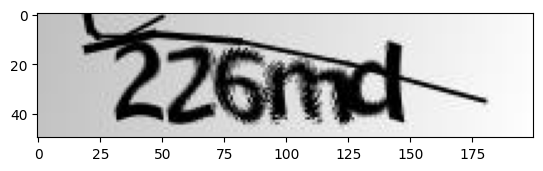

In [4]:
import string

import matplotlib.pyplot as plt
import glob

import tqdm
from PIL import Image

imgfile = glob.glob(
    "/content/drive/MyDrive/Colab Notebooks/data/CH12/*.png"
    )[0]  # 이미지까지의 경로
imgfile = Image.open(imgfile)  # 이미지를 읽어옴

plt.imshow(imgfile)
plt.show()

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 학습용 데이터셋 만들기

In [6]:
import numpy as np

from torch.utils.data.dataset import Dataset


# 문자들로부터 BOW를 만드는 함수
def get_BOW(corpus):
   # 공백문자 <pad>를 0으로 설정
   BOW = {"<pad>":0}

   # corpus의 문자들을 이용해 BOW에 고유번호 추가
   for letter in corpus:
       if letter not in BOW.keys():
           BOW[letter] = len(BOW.keys())

   return BOW


class Captcha(Dataset):
   def __init__(self, pth, train=True):
       # 소문자와 숫자만 정답으로 이용
       self.corpus = string.ascii_lowercase + string.digits
       self.BOW = get_BOW(self.corpus)

       # 불러올 이미지 파일의 경로
       self.imgfiles = glob.glob(pth+"/*.png")

       self.train = train
       self.trainset = self.imgfiles[:int(len(self.imgfiles)*0.8)]
       self.testset = self.imgfiles[int(len(self.imgfiles)*0.8):]

   # 문자와 숫자를 고유번호로 치환
   def get_seq(self, line):
       label = []
       print(line)

       for letter in line:
           label.append(self.BOW[letter])

       return label

   def __len__(self):
       if self.train:
           return len(self.trainset)
       else:
           return len(self.testset)

   def __getitem__(self, i):
       if self.train:
           # png파일을 RGB파일로 변환
           data = Image.open(self.trainset[i]).convert("RGB")

           label = self.trainset[i].split("/")[-1]
           # 파일이름에서 확장자를 제거
           label = label.split(".png")[0]
           # 정답 문자열을 BOW의 순열로 변환
           label = self.get_seq(label)

           data = np.array(data).astype(np.float32)
           # 파이토치는 채널이 가장 앞에 와야 함
           data = np.transpose(data, (2, 0, 1))
           label = np.array(label)

           return data, label

       else:
           data = Image.open(self.testset[i]).convert("RGB")
           label = self.testset[i].split("/")[-1]
           label = label.split(".png")[0]
           label = self.get_seq(label)

           data = np.array(data).astype(np.float32)
           label = np.array(label)

           return data, label

# 기본 블록 정의

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# 3X5 크기의 커널을 이용
class BasicBlock(nn.Module):
   def __init__(self, 
                in_channels, 
                out_channels, 
                kernel_size=(3, 5), 
                stride=(2, 1)):
       super(BasicBlock, self).__init__()

       self.c1 = nn.Conv2d(in_channels=in_channels, 
                           out_channels=out_channels,
                           kernel_size=kernel_size, 
                           stride=stride)
       self.c2 = nn.Conv2d(in_channels=out_channels, 
                           out_channels=out_channels,
                           kernel_size=(3, 3), padding=1)

       self.downsample = nn.Conv2d(in_channels=in_channels, 
                                   out_channels=out_channels,
                                   kernel_size=kernel_size, 
                                   stride=stride)

       self.bn1 = nn.BatchNorm2d(num_features=out_channels)
       self.bn2 = nn.BatchNorm2d(num_features=out_channels)

       self.relu = nn.ReLU()

   def forward(self, x):
       x_ = x

       x = self.c1(x)
       x = self.bn1(x)
       x = self.relu(x)
       x = self.c2(x)
       x = self.bn2(x)

       x_ = self.downsample(x_)

       x += x_
       x = self.relu(x)

       return x

# CRNN 모델 정의

In [8]:
class CRNN(nn.Module):
   def __init__(self, output_size):
       super(CRNN, self).__init__()

       # CNN층의 정의
       self.c1 = BasicBlock(in_channels=3, out_channels=64)
       self.c2 = BasicBlock(in_channels=64, out_channels=64)
       self.c3 = BasicBlock(in_channels=64, out_channels=64)
       self.c4 = BasicBlock(in_channels=64, out_channels=64)
       self.c5 = nn.Conv2d(64, 64, kernel_size=(2, 5))

       # 텍스트 정보를 추출할 GRU층
       self.gru = nn.GRU(64, 64, batch_first=False)

       # 분류를 위한 MLP층
       self.fc1 = nn.Linear(in_features=64, out_features=128)
       self.fc2 = nn.Linear(in_features=128, out_features=output_size)
       self.relu = nn.ReLU()

   def forward(self, x):
       # 입력텐서의 모양(B, 3, 50, 200)
       x = self.c1(x)
       x = self.c2(x)
       x = self.c3(x)
       x = self.c4(x)
       x = self.c5(x)
       # 특징 추출 후 텐서의 모양(B, 64, 1, 180)

       # (B, 64, 180)으로 모양을 변경
       x = x.view(x.shape[0], 64, -1)
       # (B, 180, 64)로 모양을 변경
       x = x.permute(2, 0, 1)

       # GRU로 시계열 정보 추출
       x, _ = self.gru(x)

       # FC층으로 각 픽셀 분류
       x = self.fc1(x)
       x = self.relu(x)
       x = self.fc2(x)

       #CTC 손실 계산을 위해 로그 소프트맥스를 이용
       x = F.log_softmax(x, dim=-1)

       return x

# 모델 학습하기

In [9]:
from torch.utils.data.dataloader import DataLoader
from torch.optim.adam import Adam

device = "cuda" if torch.cuda.is_available() else "cpu"

dataset = Captcha(
    pth="/content/drive/MyDrive/Colab Notebooks/data/CH12"
    )
loader = DataLoader(dataset, batch_size=8)

model = CRNN(output_size=len(dataset.BOW)).to(device)

optim = Adam(model.parameters(), lr=0.0001)

for epoch in range(200):
   iterator = tqdm.tqdm(loader)

   # ❷ 정답에 사용할 label
   for data, label in iterator:
       optim.zero_grad()
       preds = model(data.to(device))  # ❶ CRNN의 출력값
      
       # CTC 손실 계산은 텐서의 모양까지 넣어줘야 함
       # 정수형으로 간단하게 preds와 label의 모양을 만들어주자

       # ❸ 시계열을 묶은 모양을 나타내는 변수
       preds_size = torch.IntTensor([preds.size(0)] * 8).to(device)
       # ➍ 정답의 모양을 나타내는 변수
       target_len = torch.IntTensor([len(txt) for txt in label]).to(device)
      
       # ➎ 손실 계산
       loss = nn.CTCLoss(blank=0)(
           preds, label.to(device), preds_size, target_len)

       loss.backward()   # ➏ 역전파
       optim.step()

       iterator.set_description(f"epoch{epoch+1} loss:{loss.item()}")

torch.save(model.state_dict(), "CRNN.pth")

  0%|          | 0/84 [00:00<?, ?it/s]

226md
22d5n
243mm
2356g
245y5
23mdg
244e2
5np4m


epoch1 loss:121.95246887207031:   1%|          | 1/84 [00:06<08:33,  6.18s/it]

2cg58
56c34
7cdge
5mcy7
7634y
76353
34pcn
8nbew


epoch1 loss:116.40046691894531:   2%|▏         | 2/84 [00:16<12:03,  8.82s/it]

7m8px
47e4p
5n3w4
8ypdn
2xc2n
3nw7w
8b735
2bg48


epoch1 loss:115.97386932373047:   4%|▎         | 3/84 [00:18<07:21,  5.45s/it]

87d4c
5325m
7dyww
3w2bw
55w5c
646x8
78eec
42dw4


epoch1 loss:114.031005859375:   5%|▍         | 4/84 [00:19<05:09,  3.87s/it]

7bb7b
8cm46
7pcd7
7dxbd
5dxnm
6ge3p
57b27
87nym


epoch1 loss:107.27639770507812:   6%|▌         | 5/84 [00:20<03:48,  2.90s/it]

2b827
5bg8f
8e32m
728n8
4gb3f
4exnn
7e2y7
b35f6


epoch1 loss:111.1113510131836:   7%|▋         | 6/84 [00:21<02:54,  2.24s/it]

8gf7n
6ecbn
8cccc
3pe4g
4cfw8
7cgym
6n6gg
377xx


epoch1 loss:112.35676574707031:   8%|▊         | 7/84 [00:22<02:19,  1.81s/it]

253dc
662bw
68wfd
4cn7b
467d5
7gp47
b2nen
3ny45


epoch1 loss:106.30950164794922:  10%|▉         | 8/84 [00:23<01:54,  1.51s/it]

3bx86
7wnpm
5expp
537nf
68x48
3nfdn
8n5p3
6gnm3


epoch1 loss:107.67807006835938:  11%|█         | 9/84 [00:24<01:39,  1.32s/it]

b2g8e
b4y5x
4c8n8
43gey
4w6mw
6ng6w
6fgdw
3x5fm


epoch1 loss:109.05516052246094:  12%|█▏        | 10/84 [00:25<01:28,  1.19s/it]

42nxy
88y52
368y5
2cegf
28x47
7gmf3
66wp5
6dd2y


epoch1 loss:105.26590728759766:  13%|█▎        | 11/84 [00:26<01:20,  1.10s/it]

6825y
56m6y
58b5m
4ycex
32dnn
325fb
5ywwf
33n73


epoch1 loss:106.74786376953125:  14%|█▍        | 12/84 [00:27<01:17,  1.08s/it]

36nx4
7g3nf
4fp5g
428b6
8n65n
6end3
65ebm
6mygb


epoch1 loss:99.1851577758789:  15%|█▌        | 13/84 [00:28<01:13,  1.03s/it]

6f2yc
3bfnd
5x7x5
6n5fd
5f3gf
75pfw
6e6pn
36w25


epoch1 loss:100.27713012695312:  17%|█▋        | 14/84 [00:29<01:09,  1.01it/s]

53mn8
64b3p
6fn84
85622
47m2b
38n57
53wb8
3nnpw


epoch1 loss:103.57122039794922:  18%|█▊        | 15/84 [00:30<01:06,  1.04it/s]

3bd8f
5bgp2
7gce6
5wddw
3d7bd
556wd
658xe
8np22


epoch1 loss:102.32453155517578:  19%|█▉        | 16/84 [00:31<01:11,  1.05s/it]

74eyg
2npg6
8d8ep
6xen4
6cm6m
82fx2
373gb
4n2yg


epoch1 loss:104.74993133544922:  20%|██        | 17/84 [00:32<01:17,  1.16s/it]

7nnnx
4dw3w
34fxm
7gnge
8c2wy
28348
5x5nx
8d4wm


epoch1 loss:113.48528289794922:  21%|██▏       | 18/84 [00:34<01:22,  1.24s/it]

44c22
43mn5
b43nw
24pew
25m6p
57gnx
4yc85
b3xpn


epoch1 loss:106.74915313720703:  23%|██▎       | 19/84 [00:35<01:20,  1.24s/it]

2pfpn
8bbw8
664nf
37ep6
64m82
25p2m
378e5
7f8b3


epoch1 loss:99.89056396484375:  24%|██▍       | 20/84 [00:36<01:12,  1.13s/it]

664dn
8n5pn
5bb66
3b4we
2cgyx
7yf62
5n245
6cwxe


epoch1 loss:97.56488800048828:  25%|██▌       | 21/84 [00:37<01:07,  1.07s/it]

6g45w
b5dn4
76nxn
573bn
2g783
b5fm7
574d7
42xpy


epoch1 loss:99.00748443603516:  26%|██▌       | 22/84 [00:38<01:03,  1.02s/it]

2nbcx
7dwx4
b28g8
5pm6b
6mn8n
43p5d
7wn74
8n2pg


epoch1 loss:100.98240661621094:  27%|██▋       | 23/84 [00:39<01:00,  1.01it/s]

6mege
6bxwg
55y2m
5mfff
8nn73
478nx
8npe3
62nb3


epoch1 loss:100.84815979003906:  29%|██▊       | 24/84 [00:39<00:58,  1.03it/s]

8n56m
2nx38
3xng6
3ndxd
7mgmf
7xd5m
8wy7d
678w3


epoch1 loss:101.8274154663086:  30%|██▉       | 25/84 [00:40<00:55,  1.06it/s]

3den6
6bnnm
8bbm4
3g2w6
7xcyd
3ebnn
88bgx
4b2pw


epoch1 loss:93.66447448730469:  31%|███       | 26/84 [00:41<00:53,  1.08it/s]

33p4e
677g3
8y63f
3n2b4
33f7m
6xxdx
34b84
488de


epoch1 loss:98.3251724243164:  32%|███▏      | 27/84 [00:42<00:52,  1.09it/s]

6fg8c
b4ncn
7fde7
57wdp
5ep3n
2wx73
3bnyf
8gmnx


epoch1 loss:100.9166259765625:  33%|███▎      | 28/84 [00:43<00:51,  1.09it/s]

2x7bm
8g4yp
7p852
3dgmf
823p2
8w875
6c3p5
25257


epoch1 loss:102.59516143798828:  35%|███▍      | 29/84 [00:44<00:49,  1.10it/s]

4gycb
3mxdn
33b22
43xfe
4433m
5fyem
264m5
3n3cf


epoch1 loss:102.23545837402344:  36%|███▌      | 30/84 [00:45<00:51,  1.04it/s]

33ng4
4w76g
8n4n8
6ng6n
832f3
6pwcn
8w754
8y6b3


epoch1 loss:96.69686126708984:  37%|███▋      | 31/84 [00:47<00:58,  1.11s/it]

4743p
37d52
5n728
2n73f
4dgf7
4egem
3p67n
2nf26


epoch1 loss:99.97415161132812:  38%|███▊      | 32/84 [00:48<01:02,  1.20s/it]

3wnd3
8n62n
8gmc4
6f857
72m6f
5mnpd
76n7p
7b4bm


epoch1 loss:93.6244888305664:  39%|███▉      | 33/84 [00:49<01:03,  1.25s/it]

3fbxd
2ycn8
7wyp4
85dxn
4f8yp
3p4nn
8c23f
474ff


epoch1 loss:103.39873504638672:  40%|████      | 34/84 [00:50<00:57,  1.15s/it]

8pfxx
5xd2e
b5nmm
2en7g
3ebpw
5mf7c
387g2
b4d7c


epoch1 loss:98.52024841308594:  42%|████▏     | 35/84 [00:51<00:52,  1.08s/it]

5gcd3
2p2y8
36bc2
5nggg
24f6w
8gecm
573d8
6wb76


epoch1 loss:94.78107452392578:  43%|████▎     | 36/84 [00:52<00:49,  1.03s/it]

56ncx
6wnyc
4m2w5
53wp3
63pxe
865wm
675p3
6ydyp


epoch1 loss:88.76128387451172:  44%|████▍     | 37/84 [00:53<00:46,  1.01it/s]

2mg87
6p7gx
2mpnn
25egp
5p3mm
8fexn
3xcgg
7pn5g


epoch1 loss:97.96540069580078:  45%|████▌     | 38/84 [00:54<00:43,  1.05it/s]

84w7x
8db67
b26nd
44xe8
4nc37
6e554
5g5e5
6p2ge


epoch1 loss:91.8272705078125:  46%|████▋     | 39/84 [00:55<00:42,  1.06it/s]

3x325
445cc
3cpwb
65m85
4nnf3
g7wxw
dyxnc
e72cd


epoch1 loss:95.84516143798828:  48%|████▊     | 40/84 [00:56<00:41,  1.07it/s]

x4f7g
nfcwy
n4b4m
ncww7
w48cw
ypw3d
cfw6e
mxyxw


epoch1 loss:95.74140930175781:  49%|████▉     | 41/84 [00:57<00:39,  1.09it/s]

x8e8n
nfg23
c3n8x
mp7wp
dn26n
n5w5g
xcf88
c753e


epoch1 loss:95.3436050415039:  50%|█████     | 42/84 [00:57<00:38,  1.10it/s]

nwg2m
bny4w
emwpn
dd764
e6m6p
xxw44
mddgb
y33nm


epoch1 loss:91.18148803710938:  51%|█████     | 43/84 [00:58<00:37,  1.09it/s]

fbp2c
gf2g4
ppwyd
p5nce
nbcgb
gnbde
y4ec2
x2cnn


epoch1 loss:91.79312133789062:  52%|█████▏    | 44/84 [00:59<00:37,  1.08it/s]

c4mcm
bcwnn
dn2ym
w4x2m
x6pdb
exycn
bnc5f
f6ne5


epoch1 loss:89.5911636352539:  54%|█████▎    | 45/84 [01:01<00:42,  1.09s/it]

nm46n
y866y
bm3p8
npxb7
gc2wd
y5n6d
pwn5e
m4g8g


epoch1 loss:87.82728576660156:  55%|█████▍    | 46/84 [01:02<00:45,  1.20s/it]

nd5wg
yyn57
x5nyn
cdmn8
fy2nd
n6f4b
ny5dp
ncfgb


epoch1 loss:87.86214447021484:  56%|█████▌    | 47/84 [01:04<00:47,  1.27s/it]

wd2gb
f35xp
g78gn
yew6p
mmg38
w46ep
pbpgc
deep5


epoch1 loss:85.97684478759766:  57%|█████▋    | 48/84 [01:05<00:42,  1.17s/it]

yyg5g
x74b2
yx2d4
mgw3n
d3c7y
dy3cx
yf28d
pme86


epoch1 loss:83.17318725585938:  58%|█████▊    | 49/84 [01:05<00:38,  1.09s/it]

efb3f
w2n7e
efe62
fywb8
y7d75
c2fb7
wyc25
m4fd8


epoch1 loss:80.01029205322266:  60%|█████▉    | 50/84 [01:06<00:35,  1.03s/it]

gnf85
x3fwf
een23
xfg65
x3deb
nngxc
cpe63
mgdwb


epoch1 loss:77.83445739746094:  61%|██████    | 51/84 [01:07<00:33,  1.00s/it]

dmx8p
xmcym
wmpmp
d8dce
n7ebx
nfcb5
pgwnp
c4bny


epoch1 loss:75.96791076660156:  62%|██████▏   | 52/84 [01:08<00:31,  1.03it/s]

n464c
cm6yb
md344
mb4en
cd6p4
d666m
c43b4
mc8w2


epoch1 loss:74.11907958984375:  63%|██████▎   | 53/84 [01:09<00:29,  1.05it/s]

p6mn8
enpw2
gcfgp
gn2xy
byfgn
g7gnf
wwmn6
dw3nn


epoch1 loss:72.43362426757812:  64%|██████▍   | 54/84 [01:10<00:27,  1.07it/s]

byc82
ndme7
e46yw
ennmm
g6n7x
dw6mn
fcne6
dnne7


epoch1 loss:70.76013946533203:  65%|██████▌   | 55/84 [01:11<00:26,  1.09it/s]

pmf5w
ddpyb
n8pfe
pnnwy
gm7n8
mbp2y
ygfwe
wnmyn


epoch1 loss:69.21499633789062:  67%|██████▋   | 56/84 [01:12<00:25,  1.10it/s]

mmfm6
w4nfx
men4f
c6f8g
dc436
ccf2w
pnmxf
gcx6f


epoch1 loss:67.73859405517578:  68%|██████▊   | 57/84 [01:13<00:24,  1.11it/s]

p24gn
xp24p
nf7bn
dfnx4
bgem5
n336e
edwny
w7e6m


epoch1 loss:66.07078552246094:  69%|██████▉   | 58/84 [01:14<00:23,  1.11it/s]

pf4nb
pg2pm
ep85x
gnc3n
gpxng
e8e5e
m2nf4
wecfd


epoch1 loss:64.55147552490234:  70%|███████   | 59/84 [01:15<00:25,  1.03s/it]

wce5n
cnex4
ee8fg
ppx77
ny3dw
ng6yp
yeyn4
ffd6p


epoch1 loss:62.928104400634766:  71%|███████▏  | 60/84 [01:16<00:27,  1.15s/it]

dw8d3
en32e
de7f8
x458w
dbex3
mpmy5
c8fxy
fyfbn


epoch1 loss:61.415225982666016:  73%|███████▎  | 61/84 [01:18<00:28,  1.23s/it]

f85y3
d22n7
dmxp8
w6yne
fcey3
ef4np
ewcf5
e7nx4


epoch1 loss:59.85564422607422:  74%|███████▍  | 62/84 [01:19<00:26,  1.21s/it]

ecd4w
xngxc
mcc2x
dn5df
y5w28
wxy4n
by5y3
n3x4c


epoch1 loss:58.528682708740234:  75%|███████▌  | 63/84 [01:20<00:23,  1.11s/it]

b5pnn
enn7n
yxd7m
x6b5m
mxnw4
y2xg4
deneb
yf347


epoch1 loss:57.0301399230957:  76%|███████▌  | 64/84 [01:21<00:20,  1.04s/it]

e7x45
xgcxy
gxxpf
wgnwp
pyf65
pcede
gwnm6
nmw46


epoch1 loss:55.72905349731445:  77%|███████▋  | 65/84 [01:22<00:18,  1.00it/s]

cen55
nnf8b
x37bf
pwebm
wm47f
wb3ed
neecd
cdf77


epoch1 loss:54.40746307373047:  79%|███████▊  | 66/84 [01:22<00:17,  1.03it/s]

dnmd8
m3588
ny8np
xnnc3
g2fnw
pxne8
y4g3b
cwgyx


epoch1 loss:53.31588363647461:  80%|███████▉  | 67/84 [01:23<00:16,  1.05it/s]

px2xp
nbwnn
dce8y
yf424
nf2n8
xc68n
ngn26
f22bn


epoch1 loss:52.10505676269531:  81%|████████  | 68/84 [01:24<00:15,  1.07it/s]

wxcn8
nxcmn
pg2yx
yd38e
x7422
bc8nf
f2m8n
y7mnm


epoch1 loss:50.97312545776367:  82%|████████▏ | 69/84 [01:25<00:13,  1.08it/s]

gbxyy
e76n4
d22y5
d7nn3
ddmyg
n4xx5
f5e5e
e2d66


epoch1 loss:49.509010314941406:  83%|████████▎ | 70/84 [01:26<00:12,  1.08it/s]

e2mg2
wye85
dnxdp
gymmn
fp3wy
nw5b2
ng756
nxxf8


epoch1 loss:48.46736526489258:  85%|████████▍ | 71/84 [01:27<00:11,  1.09it/s]

mnef5
e667x
d75b5
fp382
y5dpp
mx8bb
e5n66
gc277


epoch1 loss:47.089176177978516:  86%|████████▌ | 72/84 [01:28<00:10,  1.10it/s]

mdxpn
w75w8
fg7mg
f74x3
wf684
d66cn
x8xnp
gng6e


epoch1 loss:46.34156036376953:  87%|████████▋ | 73/84 [01:29<00:10,  1.03it/s]

wm746
cc845
p5g5m
xnfx5
n4wwn
x775w
d8xcn
ygenn


epoch1 loss:45.381011962890625:  88%|████████▊ | 74/84 [01:30<00:11,  1.11s/it]

ypp8f
c2pg6
bdg84
xemyg
e8dxn
b685n
ydg8n
egxmp


epoch1 loss:44.43067932128906:  89%|████████▉ | 75/84 [01:32<00:10,  1.21s/it]

xcmbp
yw7ny
c86md
g55b4
c7nn8
my84e
m2576
bp6mw


epoch1 loss:43.43382263183594:  90%|█████████ | 76/84 [01:33<00:09,  1.25s/it]

nnn57
dxwcw
f7cey
f75cx
nny5e
mbf58
c353e
eppg3


epoch1 loss:42.56650161743164:  92%|█████████▏| 77/84 [01:34<00:08,  1.14s/it]

f364x
g3ex3
nbmx7
gp7c5
befbd
m67b3
ncw4g
ddcdd


epoch1 loss:41.737464904785156:  93%|█████████▎| 78/84 [01:35<00:06,  1.08s/it]

x7746
gdng3
cfc56
f6ww8
d3ycn
nnp4e
pcpg6
excmn


epoch1 loss:40.90230941772461:  94%|█████████▍| 79/84 [01:36<00:05,  1.02s/it]

f8f8g
ddcne
dbpcd
y5g87
xnn4d
d3c8y
pwmbn
cffp4


epoch1 loss:40.077613830566406:  95%|█████████▌| 80/84 [01:37<00:03,  1.02it/s]

p57fn
wc2bd
pmd3w
gm2c2
cnmnn
d7en3
nm248
g8gnd


epoch1 loss:39.252540588378906:  96%|█████████▋| 81/84 [01:38<00:02,  1.04it/s]

cfp86
pm363
be6np
yy824
ewnx8
gw53m
ncyx8
bw5ym


epoch1 loss:38.29621124267578:  98%|█████████▊| 82/84 [01:39<00:01,  1.06it/s]

gxx2p
bnc2f
be3bp
y53c2
bxxfc
pdw38
w52fn
m23bp


epoch1 loss:37.535797119140625:  99%|█████████▉| 83/84 [01:40<00:01,  1.21s/it]


p4pde


RuntimeError: ignored

# 모델 성능 평가하기

In [ ]:
model.load_state_dict(torch.load("CRNN.pth", map_location=device))

with torch.no_grad():

   testset = Captcha(pth="데이터까지의 경로 복사", train=False)
   test_img, label = testset[0]
   input_tensor = torch.unsqueeze(torch.tensor(test_img), dim=0)
   input_tensor = input_tensor.permute(0, 3, 1, 2).to(device)

   # 가장 높은 확률을 갖는 글자를 추출
   pred = torch.argmax(model(input_tensor), dim=-1)

   # ➊ 글자 간의 중복을 제거
   prev_letter = pred[0].item()
   pred_word = ""
   for letter in pred:
       if letter.item() != 0 and letter.item() != prev_letter:
           pred_word += list(testset.BOW.keys())[letter.item()]
       prev_letter = letter.item()

   plt.imshow(test_img)
   plt.title("prediction: "+pred_word)
   plt.show()